In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')



In [4]:
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,confusion_matrix,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC  
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

### data description
1. **SeriousDlqin2yrs**- Person experienced 90 days past due delinquency or worse Y/N
2. **RevolvingUtilizationOfUnsecuredLines**- Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits percentage : debt/limit ratio
3. **age** - Age of borrower in years integer
4. **NumberOfTime30-59DaysPastDueNotWorse** - Number of times borrower has been 30-59 days past due but no worse in the last 2 years. integer
5. **DebtRatio** -Monthly debt payments, alimony,living costs divided by monthy gross income percentage
6. **MonthlyIncome**- Monthly income real
7. **NumberOfOpenCreditLinesAndLoans**- Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) integer
8. **NumberOfTimes90DaysLate**- Number of times borrower has been 90 days or more past due. integer
9. **NumberRealEstateLoansOrLines**- Number of mortgage and real estate loans including home equity lines of credit integer
10. **NumberOfTime60-89DaysPastDueNotWorse**- Number of times borrower has been 60-89 days past due but no worse in the last 2 years. integer
11. **NumberOfDependents** - Number of dependents in family excluding themselves (spouse, children etc.) integer


In [5]:
# Load the data
train = pd.read_csv('C:/Users/RUPA/Downloads/fin_distress.csv')

# First 5 columns
train.head()
# print(df.shape) =(150000,12)
#=================================


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


##### NumberOfDependents=3924 rows : 2.6 % null , expected data type: float
##### MonthlyIncome=29731 rows   : 19.82 % null, expected datatype: float

## EDA of the data given:

### SeriousDlqin2yrs= history of serious delinquency in past 2 years 
1 : represents defaulted

0 : represents not defaulted


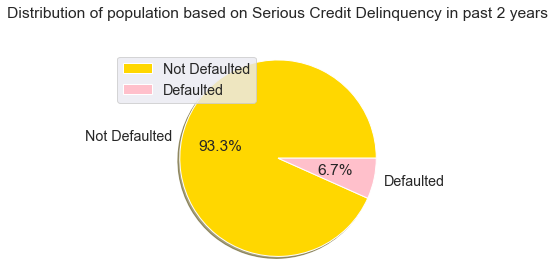

In [6]:
train['SeriousDlqin2yrs'].value_counts()
value = [139974,10026]
colors_list = ['gold', 'pink']
my_labels = 'Not Defaulted','Defaulted'
plt.pie(value,labels=my_labels,autopct='%1.1f%%',shadow=True,colors=colors_list)
plt.title('Distribution of population based on Serious Credit Delinquency in past 2 years', y=1.12) 
plt.axis('equal') 
plt.legend(labels=my_labels, loc='upper left') 
plt.axis('equal')
plt.show()

In [7]:
train["RevolvingUtilizationOfUnsecuredLines"].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

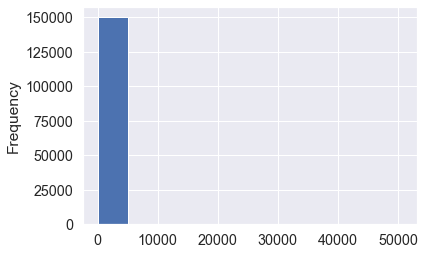

In [8]:
train["RevolvingUtilizationOfUnsecuredLines"].describe()
train['RevolvingUtilizationOfUnsecuredLines'].plot.hist(bins=10, alpha=1)

In [9]:
# print("Proportion of Defaulters with Total Amount of Money Owed Not Exceeding Total Credit Limit: {}"
      
x=format(train.loc[(train["RevolvingUtilizationOfUnsecuredLines"] >= 0) & (train["RevolvingUtilizationOfUnsecuredLines"] <=1)]["SeriousDlqin2yrs"].mean())

x

'0.05991996127598361'

## age  : 
There seems to be more younger people defaulting and the distribution seems fine on the whole

In [10]:
train["age"].describe()

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

In [11]:
train[train['age'] == 0]
# There is just one individual with a 0 value. We can probably attribute it to an input 
#error and impute with the median value.
train['age'].median()
train['age'].replace(0, train['age'].median(), inplace=True)
#We see that our youngest individual is 21 which makes more sense.


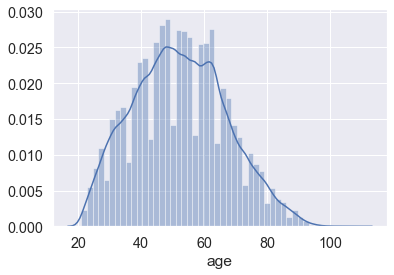

In [12]:
sns.distplot(train["age"])

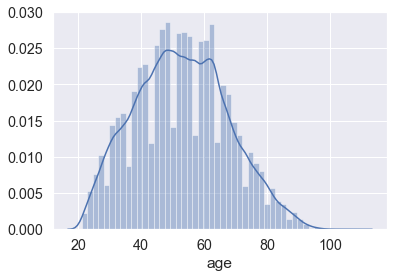

In [13]:
sns.distplot(train.loc[train["SeriousDlqin2yrs"] == 0]["age"])

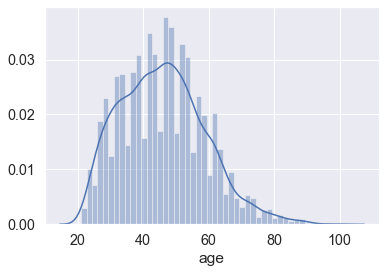

In [14]:
sns.distplot(train.loc[train["SeriousDlqin2yrs"] == 1]["age"])

## late payments columns
1. NumberOfTimes90DaysLate
2. NumberOfTime60-89DaysPastDueNotWorse
3. NumberOfTime30-59DaysPastDueNotWorse

In [15]:
late_pay_cols = ["NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse",
                "NumberOfTime30-59DaysPastDueNotWorse"]
train["NumberOfTimes90DaysLate"].value_counts().sort_index()

0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64

In [16]:
train["NumberOfTime60-89DaysPastDueNotWorse"].value_counts().sort_index()
 # no one who is 60-89 days past due between 11 and 96 times.

0     142396
1       5731
2       1118
3        318
4        105
5         34
6         16
7          9
8          2
9          1
11         1
96         5
98       264
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

In [17]:
train["NumberOfTime30-59DaysPastDueNotWorse"].value_counts()

0     126018
1      16033
2       4598
3       1754
4        747
5        342
98       264
6        140
7         54
8         25
9         12
96         5
10         4
12         2
13         1
11         1
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

**Looking at the values for the number of times each individual were 30-59 days past due on their payments, I noticed that there were 2 extreme values. The values of 96 and 98 were a big jump from the next highest value of 13. It would seem that these 2 values represent a qualitative aspect of the variable and were mixed in together with the other quantitative values.**

In [18]:
train[train['NumberOfTime30-59DaysPastDueNotWorse'] == 96]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
41944,41945,1,1.0,26,96,0.000000,NaN,0,96,0,96,0.0
69478,69479,1,1.0,33,96,0.008047,4100.0,0,96,0,96,0.0
84167,84168,1,1.0,29,96,0.000000,2800.0,0,96,0,96,2.0
94106,94107,1,1.0,34,96,0.000000,3500.0,0,96,0,96,1.0
120049,120050,0,1.0,46,96,0.051765,4616.0,0,96,0,96,0.0


**By looking only at the observations with values 96 and 98 in the 30-59 days variable, we notice a pattern start to emerge. The same value is found in the >=90days and 60-89days variables as well, all of these observations have a revolvingcreditrate of 1.0 and the debtratio is majority 0**

In [19]:
train[train["NumberOfTimes90DaysLate"] > 96][late_pay_cols].describe()

#It is interesting to note that there are no one who is 90 
#or more days past due between 17 and 96 times.

,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse
count,264.0,264.0,264.0
mean,98.0,98.0,98.0
std,0.0,0.0,0.0
min,98.0,98.0,98.0
25%,98.0,98.0,98.0
50%,98.0,98.0,98.0
75%,98.0,98.0,98.0
max,98.0,98.0,98.0


## debt ratio

In [20]:
train["DebtRatio"].describe()

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

In [21]:
train["DebtRatio"].quantile(0.95)

2449.0

In [22]:
train[train["DebtRatio"]<1]
# 95% of the values in debt ratio columns is less than 2449
# 5% population has debt ratio greater than 2449: their debt is 2449 times their income
len(train[(train["DebtRatio"] > train["DebtRatio"].quantile(0.95)) & (train['SeriousDlqin2yrs'] == train['MonthlyIncome'])])

331

In [23]:
train.loc[train["DebtRatio"] > train["DebtRatio"].quantile(0.95)]["MonthlyIncome"].value_counts()

0.0    347
1.0     32
Name: MonthlyIncome, dtype: int64

In [24]:
print("Number of people who owe around 2449 or more times what they own and have same values for MonthlyIncome and SeriousDlqin2yrs: {}"\
     .format(len(train.loc[(train["DebtRatio"] > train["DebtRatio"].quantile(0.95)) & (train["MonthlyIncome"] == train["SeriousDlqin2yrs"])])))

Number of people who owe around 2449 or more times what they own and have same values for MonthlyIncome and SeriousDlqin2yrs: 331


In [25]:
train["DebtRatio"].quantile(0.975)

3489.024999999994

In [26]:
train.loc[train["DebtRatio"] > train["DebtRatio"].quantile(0.95)][["DebtRatio", "MonthlyIncome", "SeriousDlqin2yrs"]].describe()

,DebtRatio,MonthlyIncome,SeriousDlqin2yrs
count,7494.000000,379.000000,7494.000000
mean,4417.958367,0.084433,0.055111
std,7875.314649,0.278403,0.228212
min,2450.000000,0.000000,0.000000
25%,2893.250000,0.000000,0.000000
50%,3491.000000,0.000000,0.000000
75%,4620.000000,0.000000,0.000000
max,329664.000000,1.000000,1.000000


In [27]:
train[(train["DebtRatio"] > train["DebtRatio"].quantile(0.95)) & (train['SeriousDlqin2yrs'] == train['MonthlyIncome'])].describe()
# length=331

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,70480.851964,0.009063,0.346688,50.178248,0.232628,4620.460725,0.009063,10.329305,0.021148,1.679758,0.045317,1.208459
std,42895.128501,0.094913,0.346070,11.127972,0.667623,4796.584515,0.094913,4.988807,0.144096,0.907969,0.248146,1.423415
min,51.000000,0.000000,0.000000,26.000000,0.000000,2451.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,33436.000000,0.000000,0.047404,42.000000,0.000000,2850.500000,0.000000,7.000000,0.000000,1.000000,0.000000,0.000000
50%,67938.000000,0.000000,0.250410,48.000000,0.000000,3481.000000,0.000000,10.000000,0.000000,2.000000,0.000000,1.000000
75%,106623.000000,0.000000,0.580508,58.000000,0.000000,4685.000000,0.000000,13.000000,0.000000,2.000000,0.000000,2.000000
max,149674.000000,1.000000,1.648352,83.000000,4.000000,60212.000000,1.000000,31.000000,1.000000,7.000000,2.000000,10.000000


In [28]:
len(train[(train["DebtRatio"] > train["DebtRatio"].quantile(0.95)) & (train['SeriousDlqin2yrs'] != train['MonthlyIncome'])])
# lenght=7163

7163

In [29]:
train.loc[train["DebtRatio"] > train["DebtRatio"].quantile(0.95)]["MonthlyIncome"].value_counts()

0.0    347
1.0     32
Name: MonthlyIncome, dtype: int64

In [30]:
print("Number of people who owe around 2449 or more times what they own and have same values for MonthlyIncome and SeriousDlqin2yrs: {}"\
     .format(len(train.loc[(train["DebtRatio"] > train["DebtRatio"].quantile(0.95)) & (train["MonthlyIncome"] == train["SeriousDlqin2yrs"])])))

Number of people who owe around 2449 or more times what they own and have same values for MonthlyIncome and SeriousDlqin2yrs: 331


## MonthlyIncome

In [236]:
# train['monthlyincome'].describe()

In [237]:
# train["MonthlyIncome"].describe()

0.0    347
1.0     32
Name: MonthlyIncome, dtype: int64


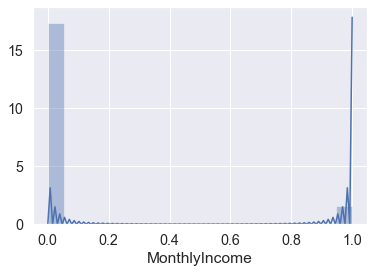

In [33]:
sns.distplot(train.loc[train["DebtRatio"] > train["DebtRatio"].quantile(0.95)]["MonthlyIncome"].dropna())
print((train.loc[train["DebtRatio"] > train["DebtRatio"].quantile(0.95)]["MonthlyIncome"].dropna()).value_counts())

## NumberOfOpenCreditLinesAndLoans

In [34]:
train["NumberOfOpenCreditLinesAndLoans"].describe()

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [35]:
#train["NumberOfOpenCreditLinesAndLoans"].value_counts()

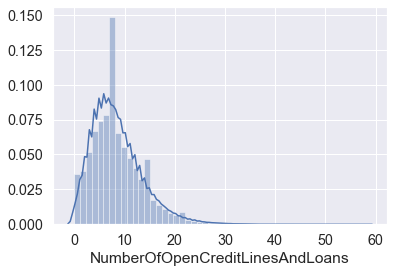

In [36]:
sns.distplot(train["NumberOfOpenCreditLinesAndLoans"])

## NumberRealEstateLoansOrLines

In [232]:
# train["NumberRealEstateLoansOrLines"].describe()

In [233]:
# train["NumberRealEstateLoansOrLines"].value_counts()

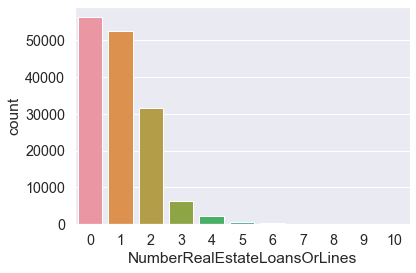

In [39]:
sns.countplot(x="NumberRealEstateLoansOrLines", data=train.loc[train["NumberRealEstateLoansOrLines"] <= 10])

In [40]:
train.loc[train["NumberRealEstateLoansOrLines"] > 13]["SeriousDlqin2yrs"].value_counts()

0    30
1     8
Name: SeriousDlqin2yrs, dtype: int64

## NumberOfDependents

In [41]:
print(train["NumberOfDependents"].value_counts())

#we can see that it is extremely right-skewed in our database, 
#with the majority of individuals with no dependents. 

0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64


In [42]:
train.loc[train["NumberOfDependents"] <= 10]["SeriousDlqin2yrs"].value_counts()

0    136227
1      9847
Name: SeriousDlqin2yrs, dtype: int64

In [43]:
train.loc[train["NumberOfDependents"] > 10]["SeriousDlqin2yrs"].value_counts()

0    2
Name: SeriousDlqin2yrs, dtype: int64

In [44]:
train.loc[train['NumberOfDependents']==20]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
6299,6300,0,0.226616,40,1,0.576539,6316.0,11,2,1,0,20.0


**This individual with the highest number of dependents doesn't look to be erroneous and should serve as a valid observation**

## conclusions of eda:
1. Around 6% of samples defaulted

2. **MonthlyIncome and NumberOfDependents** have 29731 (19.82%) and 3924 (2.61%) null values respectively

3.  when NumberOfTimes90DaysLate has values above 17, there are 267 instances where the three columns          NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTime30-59DaysPastDueNotWorse 
     share the same values, specifically 96 and 98.

4. also logically, sharing the same values of 96 and 98 respectively is not logical since trivial calculations can reveal    that being 30 days past due for 96 times for a single person within a timespan of 2 years is not possible.

5. **RevolvingUtilizationOfUnsecuredLines-**

   distribution of values is right-skewed, consider removing outliers
   It is expected that as this value increases, the proportion of people defaulting should increase as well
   However, we can see that as the minimum value of this column is set to 13, the proportion of defaulters is smaller than that belonging to the   pool of clients with total amount of money owed not exceeding total credit limit.
   Thus we should remove those samples with RevolvingUtilizationOfUnsecuredLines's value more than equal to 13
   age
   There seems to be more younger people defaulting and the distribution seems fine on the whole
6. **NumberOfTimes90DaysLate-**

   It is interesting to note that there are no one who is 90 or more days past due between 17 and 96 times.
7. **NumberOfTime60-89DaysPastDueNotWorse-**

   It is interesting to note that there are no one who is 60-89 days past due between 11 and 96 times.
8. **NumberOfTime30-59DaysPastDueNotWorse-**

   It is interesting to note that there are no one who is 30-59 days past due between 13 and 96 times.
9. **DebtRatio-**

   5% of clients owe around 2449 or more times what they own
   For the people who have monthly income in this 5%, only 379 people have values for their monthly incomes and the   values are either 0 or 1.
   Number of people who owe around 2449 or more times what they own and have same values for MonthlyIncome and SeriousDlqin2yrs: 331
   Number of people who owe around 2449 or more times what they own and dont  have same values for MonthlyIncome and  SeriousDlqin2yrs: 7163
   There are 379 ,out of these 347 have no monthly income and does not default and 32 with monthly income and does default.
10. **MonthlyIncome-**

    Distribution of values is skewed, we can consider imputation with median.
    We can also consider imputing with normally distributed values with its mean and standard deviation.
11. **Numberof Dependents-**

    We can consider imputing with its mode, which is zero
12. **NumberRealEstateLoansOrLines-**

    8  people with Number of real estate loans or lines more than 13 have defaulted.
    30 people have not defaulted

## preprocessing of data :
1. shorten long names
2. impute missing values.
3. treat outliers and unnatural values.

In [45]:
train.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [46]:
dependents_mode = train["NumberOfDependents"].mode()[0] # impute with mode for no. of dependents
train["NumberOfDependents"] = train["NumberOfDependents"].fillna(dependents_mode)

    
income_median = train["MonthlyIncome"].median()# impute with median for monthly income
train["MonthlyIncome"] = train["MonthlyIncome"].fillna(income_median)

# train['NumberOfTimes90DaysLate']=train[train['NumberOfTimes90DaysLate']>18]['NumberOfTimes90DaysLate']
    
print(" preprocessing Done...\n")
# train.isnull().sum()

 preprocessing Done...



In [238]:
# train.isnull().sum()

In [48]:
#Rename columns for easier manipulation
train.rename(columns = {'SeriousDlqin2yrs': 'delinquency', 'RevolvingUtilizationOfUnsecuredLines':'revolvingcreditrate',
                    'NumberOfTime30-59DaysPastDueNotWorse': '30-59days', 
                     'NumberOfOpenCreditLinesAndLoans':'opencredit', 'NumberOfTimes90DaysLate':'>=90days',
                    'NumberRealEstateLoansOrLines':'mortgage', 'NumberOfTime60-89DaysPastDueNotWorse':'60-89days',
                    'NumberOfDependents':'dependents'}, inplace=True)

In [49]:
train.drop('Unnamed: 0',1, inplace=True)

In [50]:
# train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
delinquency            150000 non-null int64
revolvingcreditrate    150000 non-null float64
age                    150000 non-null int64
30-59days              150000 non-null int64
DebtRatio              150000 non-null float64
MonthlyIncome          150000 non-null float64
opencredit             150000 non-null int64
>=90days               150000 non-null int64
mortgage               150000 non-null int64
60-89days              150000 non-null int64
dependents             150000 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [51]:
#Set all column headers to lower
train.columns=[x.lower() for x in train.columns]


In [231]:
# # generating correlation matrix
# fig, ax = plt.subplots(figsize=(12,12))
# sns.heatmap(train.corr(),xticklabels=train.corr().columns,yticklabels=train.corr().columns,annot=True,ax=ax)
# #sns.heatmap(train.corr())

## baseline model

In [52]:
# Independent variables
X = train.drop(['delinquency'],axis = 1)

# Dependent variable
y = train['delinquency']

# Check the value counts
count = y.value_counts()
count

0    139974
1     10026
Name: delinquency, dtype: int64

In [53]:
#  Split the data set into train and test sets 70/30 ratio
# baseline model
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 6)

In [63]:
f1 = []
def run_model(predictors,target, model):
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=6)
    model.fit(X_train, y_train)
    y_scores = model.predict(X_test)
    print('Train Accuracy:\n',model.score(X_train,y_train).round(3))
    print('Validation Accuracy:\n',model.score(X_test,y_test).round(3))
    print('Classification Report:\n',classification_report(y_test, y_scores))
    print("Precision Score : ",precision_score(y_test, y_scores,average='weighted').round(3))
    print("Recall Score : ",recall_score(y_test, y_scores,average='weighted').round(3))
    
    # calculating the f1 score for the validation set
    print("F1 score :", f1_score(y_test, y_scores,average='weighted').round(3))
    f1.append(f1_score(y_test, y_scores,average='weighted').round(3))
    print("="*120)
    return f1


In [59]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier

In [60]:
models = {'Logistic Regression':LogisticRegression()
          ,'Decision Tree':DecisionTreeClassifier()
          ,'Random Forest': RandomForestClassifier()
          ,'MNB':MultinomialNB()
          ,'LogregCV':LogisticRegressionCV(penalty='l2', Cs=200, cv=5, random_state=123)}
         # ,'gradientboost':GradientBoostingClassifier(random_state=123)}

j = 0
for i in models.items():
    print('='*50,list(models.keys())[j],'='*50)
    model = i[1]
    a = run_model(X, y, model)
    j=j+1
print('Max f1_score is {} in model {}'.format(max(a),list(models.keys())[a.index(max(a))]))

================================================== Logistic Regression ==================================================
Train Accuracy:
 0.933
Validation Accuracy:
 0.935
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     28044
           1       0.49      0.01      0.02      1956

    accuracy                           0.93     30000
   macro avg       0.71      0.51      0.50     30000
weighted avg       0.91      0.93      0.90     30000

Precision Score :  0.906
Recall Score :  0.935
F1 score : 0.905
================================================== Decision Tree ==================================================
Train Accuracy:
 1.0
Validation Accuracy:
 0.899
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95     28044
           1       0.25      0.28      0.26      1956

    accuracy                           0.90     30000
   ma

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=6)
gbc = GradientBoostingClassifier(random_state=123)
# gbc.fit(X_train, y_train)
gbc.fit(X_train, y_train)
y_gbc = gbc.predict(X_test)
print('Train Accuracy:\n',gbc.score(X_train,y_train).round(3))
print('Validation Accuracy:\n',gbc.score(X_test,y_test).round(3))
print('Classification Report:\n',classification_report(y_test, y_gbc))
print("Precision Score : ",precision_score(y_test, y_gbc,average='weighted').round(3))
print("Recall Score : ",recall_score(y_test, y_gbc,average='weighted').round(3))
    
# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_test, y_gbc,average='weighted').round(3))
#     f1.append(f1_score(y_test, y_scores,average='weighted').round(3))

Train Accuracy:
 0.938
Validation Accuracy:
 0.938
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     28044
           1       0.57      0.19      0.29      1956

    accuracy                           0.94     30000
   macro avg       0.76      0.59      0.63     30000
weighted avg       0.92      0.94      0.92     30000

Precision Score :  0.921
Recall Score :  0.938
F1 score : 0.923


### best f1 score shown by gradientboost , score=0.923
##### SMOTEENN :
We need to account for the imbalance in the classes. For that, I will be using SMOTE followed by Edited Nearest Neighbours. SMOTE oversamples the minority class followed by undersampling of the majority class by editing for nearest neighbors similarity

In [65]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

Using TensorFlow backend.


In [81]:
os_us = SMOTEENN( random_state=123, n_jobs=-1)
X_res, y_res = os_us.fit_sample(X, y)

In [82]:
from collections import Counter
print('Distribution of class labels before resampling: {}'.format(Counter(y)))
print('Distribution of class labels after resampling: {}'.format(Counter(y_res)))

Distribution of class labels before resampling: Counter({0: 139974, 1: 10026})
Distribution of class labels after resampling: Counter({1: 139974, 0: 139974})


## modelling after resampling

In [84]:
gbc.fit(X_res, y_res)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## apply cross validation

In [138]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
# from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,confusion_matrix,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [87]:
gbc_auc = cross_val_score(gbc, X_res, y_res, cv=5, scoring='roc_auc')
gbc_auc

array([0.90109627, 0.94929132, 0.94994195, 0.94941346, 0.95012047])

In [88]:
gbc_auc.mean()

0.9399726932975314

In [89]:
gbc_pp = gbc.predict_proba(X_test)
gbc_pp

array([[0.82592506, 0.17407494],
       [0.79328799, 0.20671201],
       [0.5503525 , 0.4496475 ],
       ...,
       [0.58759708, 0.41240292],
       [0.22166269, 0.77833731],
       [0.93951952, 0.06048048]])

## Hyperparameter tuning of Gradient Boosted Classifier

In [105]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

### parameter test 1 : 'n_estimators'

In [157]:
# param_test1 = {'n_estimators':range(20,81,10)}
# gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
# param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch1.fit(X_res,y_res)
# gsearch1.best_params_, gsearch1.best_score_
# output
## ({'n_estimators': 80}, 0.9486611722543079)
## takes 25 minutes to run

### parameter test 2 : 'learning rate'

In [149]:
# param_test2 = {'learning_rate':[0.05, 0.01, 0.005, 0.001]}
# gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators = 500, max_features='sqrt',random_state=10), 
# param_grid = param_test1, n_jobs=4,iid=False, cv=5)
# gsearch2.fit(X_res,y_res)
# gsearch2.best_params_, gsearch2.best_score_

# ##  output 
# #({'learning_rate': 0.05}, 0.93936734701753921)

## param_test 3 = 'min_samples_split'

In [150]:
# param_test3 = {'min_samples_split':range(2,11,2)}
# gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=50, learning_rate=0.05, max_depth=10, max_features='sqrt', random_state=123), 
# param_grid = param_test3,n_jobs=-1,iid=False, cv=5)
# gsearch3.fit(X_res,y_res)
# gsearch3.best_params_, gsearch2.best_score

##output
#({'min_samples_split': 2}, 0.9417773694251782)

## param_test 4 = 'min_samples_leaf'

In [148]:
# param_test3 = {'min_samples_leaf':range(2,11,2)}
# gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=50, learning_rate=0.05, max_depth=10, min_samples_split=2, max_features='sqrt', random_state=123), 
# param_grid = param_test3,n_jobs=-1,iid=False, cv=5)
# gsearch4.fit(X_res,y_res)
# gsearch4.best_params_, gsearch4.best_score

# ## output
# #({'min_samples_leaf': 4}, 0.94133623485389517)

## param_test 5= 'subsample'

In [152]:
# param_test5 = {'subsample':[0.6,0.7,0.8,0.9]}
# gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=50, learning_rate=0.05, max_depth=10, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', random_state=123), 
# param_grid = param_test5,n_jobs=-1,iid=False, cv=5)
# gsearch5.fit(X_res,y_res)
# gsearch5.best_params_, gsearch4.best_score

# ## output
#({'subsample': 0.8}, 0.94104853620864404)

## final GBC model with best parameters 

In [153]:
gbc_final= GradientBoostingClassifier(n_estimators=80, learning_rate=0.05, max_depth=10, min_samples_split=2, min_samples_leaf=4, subsample=0.8, max_features='sqrt', random_state=123)

In [158]:
gbc_final.fit(X_res,y_res)

## output (takes 10 minute to run)
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [159]:
gbc_auc_final = cross_val_score(gbc_final, X_res, y_res, cv=5, scoring='roc_auc')
print(gbc_auc_final)

[0.9026237  0.95747451 0.957181   0.95646746 0.95746407]


In [221]:
gbc_auc_final.mean()

0.9462421475100534

# roc-auc score improvement after hyperparameter tuning
# 0.93997======>0.94624

In [215]:
# train data prediction
yhat_gbc_pp_test = gbc_final.predict_proba(X_train)
yhat_gbc_pp_test
y_pred_test = yhat_gbc_pp_test[:,1]
print(y_pred_test.shape)
print(y_train.shape)

(120000,)
(120000,)


In [209]:
## test data prediction
yhat_gbc_pp_final = gbc_final.predict_proba(test_data)
yhat_gbc_pp_final


array([[0.50930737, 0.49069263],
       [0.85464397, 0.14535603],
       [0.95210739, 0.04789261],
       ...,
       [0.9257216 , 0.0742784 ],
       [0.92505663, 0.07494337],
       [0.65091437, 0.34908563]])

In [220]:
y_pred = yhat_gbc_pp_final[:,1]
y_pred.shape


(101503,)

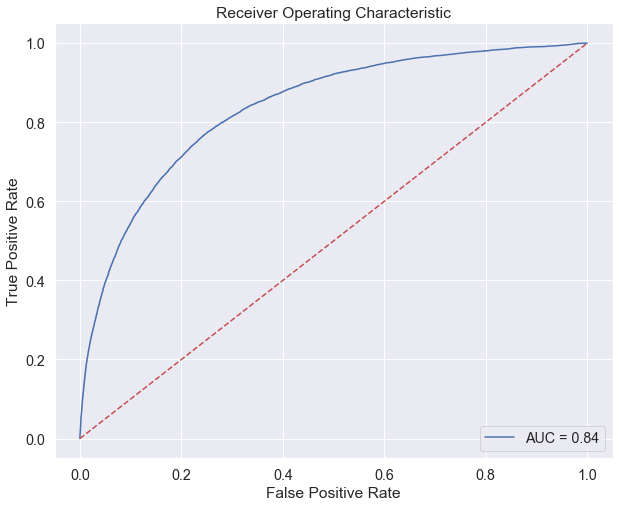

0.8371869505757437

In [226]:
from sklearn.metrics import auc,roc_curve
fpr,tpr,_ = roc_curve(y_train, y_pred_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc

## test data
We preprocess the test set in the same way we did for the training set.

In [188]:
test = pd.read_csv('C:/Users/RUPA/Downloads/fin_test.csv')

In [189]:
test.rename(columns = {'SeriousDlqin2yrs': 'delinquency', 'RevolvingUtilizationOfUnsecuredLines':'revolvingcreditrate',
                    'NumberOfTime30-59DaysPastDueNotWorse': '30-59days', 
                     'NumberOfOpenCreditLinesAndLoans':'opencredit', 'NumberOfTimes90DaysLate':'>=90days',
                    'NumberRealEstateLoansOrLines':'mortgage', 'NumberOfTime60-89DaysPastDueNotWorse':'60-89days',
                    'NumberOfDependents':'dependents','MonthlyIncome':'monthlyincome'}, inplace=True)

In [192]:
test=test.drop('Unnamed: 0',1)

In [193]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
delinquency            150000 non-null int64
revolvingcreditrate    150000 non-null float64
age                    150000 non-null int64
30-59days              150000 non-null int64
debtratio              150000 non-null float64
monthlyincome          150000 non-null float64
opencredit             150000 non-null int64
>=90days               150000 non-null int64
mortgage               150000 non-null int64
60-89days              150000 non-null int64
dependents             150000 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [194]:
dependents_mode = test["dependents"].mode()[0] # impute with mode for no. of dependents
test["dependents"] = test["dependents"].fillna(dependents_mode)

    
income_median = test["monthlyincome"].median()# impute with median for monthly income
test["monthlyincome"] = test["monthlyincome"].fillna(income_median)

# train['NumberOfTimes90DaysLate']=train[train['NumberOfTimes90DaysLate']>18]['NumberOfTimes90DaysLate']
    
print(" preprocessing Done...\n")
# train.isnull().sum()


 preprocessing Done...



In [196]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 11 columns):
delinquency            0 non-null float64
revolvingcreditrate    101503 non-null float64
age                    101503 non-null int64
30-59days              101503 non-null int64
DebtRatio              101503 non-null float64
monthlyincome          101503 non-null float64
opencredit             101503 non-null int64
>=90days               101503 non-null int64
mortgage               101503 non-null int64
60-89days              101503 non-null int64
dependents             101503 non-null float64
dtypes: float64(5), int64(6)
memory usage: 8.5 MB


In [197]:
test_data=test.drop(['delinquency'], axis=1)

 ## Submission

In [199]:
#Get 2nd column of predicted probabilities for probability of delinquency happening for each observation
sub = yhat_gbc_pp_final[:,1]

In [200]:
#Convert into dataframe and name column as probability following submission example
subdf = pd.DataFrame(sub, columns=['probability'])

In [201]:
#Increase index of all Ids by 1 to start from 1 and not 0
subdf.index += 1

In [202]:
#Rename index column as 'Id' following submission guidelines
subdf.index.name = 'Id'
subdf.head()

,probability
Id,
1,0.490693
2,0.145356
3,0.047893
4,0.332553
5,0.096034


In [239]:
#Save as csv file for submission
subdf.to_csv('sub.csv')